<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E4-SpamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

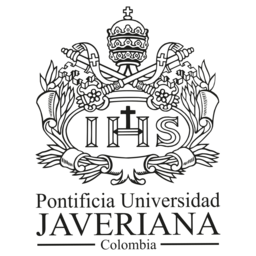

**Facultad de Ingeniería**

**Tópicos Avanzados de Analítica**

*Camila Andrea Arias Vargas*

*Felipe Clavijo Acosta*

*Joel Alfredo Márquez Álvarez*

*Juan Camilo Ramírez Restrepo*

*Juan Pablo Cuellar Solano*

# **Exercise 3**
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=47b0d561527795639ff38d8fde9be16fd557d6f7550f6da5175868271ff51c0d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-10-10 02:08:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  1.02MB/s    in 0.2s    

2024-10-10 02:08:24 (1.02 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

,count
target,
ham,0.865937
spam,0.134063


In [6]:
df ['target'].value_counts ()

,count
target,
ham,4825
spam,747


In [7]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [8]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [9]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [10]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [11]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [12]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [13]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [145]:
clrf = RandomForestClassifier()  # Clasificador de bosque aleatorio
clrf.fit(X_train, y_train)  # Entrenar con datos

RandomForestClassifier()

In [146]:
y_pred = clrf.predict(X_test)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Calcular la curva ROC

print('Accuracy:', accuracy_score(y_test, y_pred))  # Imprimir precisión
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

Accuracy: 0.94377990430622
AUC: 0.8071601223362274


In [147]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

**CountVectorizer**

In [148]:
vect = CountVectorizer()  # Inicializar vectorizador de conteo
X_dcv_tr = vect.fit_transform(X_train)  # Ajustar y transformar datos de entrenamiento
X_dcv_te = vect.transform(X_test)  # Transformar datos de prueba
clrf = RandomForestClassifier()  # Clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_dcv_tr, y_train, cv=10)).describe())  # Evaluar con validación cruzada y describir los resultados

count    10.000000
mean      0.974359
std       0.008716
min       0.958974
25%       0.969231
50%       0.975641
75%       0.978846
max       0.989744
dtype: float64


In [149]:
clrf.fit(X_dcv_tr, y_train)  # Entrenar el modelo
y_pred_cv = clrf.predict(X_dcv_te)  # Predecir con los datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cv)  # Calcular la curva ROC

In [150]:
print('Accuracy:', accuracy_score(y_test, y_pred))  # Imprimir precisión
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

Accuracy: 0.94377990430622
AUC: 0.914833267561168


**CountVectorizer (Mayus, stopwords)**

In [151]:
vect = CountVectorizer(lowercase=False, stop_words='english')  # Vectorizador con palabras en inglés como stopwords y sin convertir a minúsculas
X_dcv_tr = vect.fit_transform(X_train)  # Ajustar y transformar los datos de entrenamiento
X_dcv_te = vect.transform(X_test)  # Transformar los datos de prueba
clrf = RandomForestClassifier()  # Clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_dcv_tr, y_train, cv=10)).describe())  # Evaluar con validación cruzada y describir resultados

count    10.000000
mean      0.975897
std       0.007171
min       0.961538
25%       0.974359
50%       0.974359
75%       0.981410
max       0.984615
dtype: float64


In [152]:
clrf.fit(X_dcv_tr, y_train)  # Entrenar el modelo
y_pred_cv = clrf.predict(X_dcv_te)  # Predecir con los datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cv)  # Calcular la curva ROC

In [153]:
print('Accuracy:', accuracy_score(y_test, y_pred))  # Imprimir precisión
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

Accuracy: 0.94377990430622
AUC: 0.9189522494080506


# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [154]:
X = df['text']  # Definir las características (texto)
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas a valores numéricos (0: ham, 1: spam)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [155]:
print(X_train.shape)  # Forma de X_train
print(X_test.shape)   # Forma de X_test
print(y_train.shape)  # Forma de y_train
print(y_test.shape)   # Forma de y_test

(3900,)
(1672,)
(3900,)
(1672,)


**TdidfVectorizer**

In [157]:
tfidf = TfidfVectorizer()  # Inicializar vectorizador TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)  # Ajustar y transformar datos de entrenamiento
X_test_tfidf = tfidf.transform(X_test)  # Transformar datos de prueba
clrf = RandomForestClassifier()  # Clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train_tfidf, y_train, cv=10)).describe())  # Validación cruzada y descripción de resultados

count    10.000000
mean      0.976410
std       0.008530
min       0.961538
25%       0.972436
50%       0.976923
75%       0.982692
max       0.989744
dtype: float64


In [158]:
y_train.astype('int')  # Convertir y_train a tipo entero
y_test.astype('int')   # Convertir y_test a tipo entero

,target
5149,0
3133,0
1752,0
1503,0
2174,0
...,...
4857,0
5379,0
4768,1
2720,0


In [159]:
print(X_train_tfidf.shape)  # Forma de X_train_tfidf
print(X_test_tfidf.shape)   # Forma de X_test_tfidf

(3900, 7248)
(1672, 7248)


In [160]:
clrf.fit(X_train_tfidf, y_train)  # Entrenar el modelo

RandomForestClassifier()

In [161]:
y_pred_cv = clrf.predict(X_train_tfidf)  # Predecir con datos de entrenamiento

In [164]:
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en entrenamiento

Accuracy Train: 1.0


In [165]:
y_pred_te = clrf.predict(X_test_tfidf)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en prueba
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

Accuracy: 0.9754784688995215
AUC: 0.9084821428571428


**TdidfVectorizer (Hyperparameters)**

In [166]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5)  # Inicializar vectorizador TF-IDF con n-gramas
X_train_tfidf = tfidf.fit_transform(X_train)  # Ajustar y transformar datos de entrenamiento
X_test_tfidf = tfidf.transform(X_test)  # Transformar datos de prueba
clrf = RandomForestClassifier()  # Clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train_tfidf, y_train, cv=10)).describe())  # Validación cruzada y descripción de resultados

count    10.000000
mean      0.980000
std       0.008180
min       0.966667
25%       0.975000
50%       0.979487
75%       0.984615
max       0.994872
dtype: float64


In [167]:
clrf.fit(X_train_tfidf, y_train)  # Entrenar el modelo

RandomForestClassifier()

In [168]:
y_pred_cv = clrf.predict(X_train_tfidf)  # Predecir con datos de entrenamiento

In [169]:
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en entrenamiento


Accuracy Train: 0.9997435897435898


In [170]:
y_pred_te = clrf.predict(X_test_tfidf)  # Predecir con datos de prueba

In [171]:
y_pred_te = clrf.predict(X_test_tfidf)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en prueba
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

Accuracy: 0.9826555023923444
AUC: 0.9371546961325967


# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

De los modelos anteriores aplicados se tienen las siguientes métricas:

|Modelo | Accuracy | AUC
|-------|-----------|-----------|
|CountVectorizer| 0.9437 | 0.9148|
|CountVectorizer (Mayus, stopwords)|0.9437 |0.9189|
|TdidfVectorizer| 0.9754 | 0.9084|
|TdidfVectorizer (Hyperparameters) | 0.9826 | 0.9371|

Dado que tanto el Accuracy como el AUC son más altos en el modelo **TfidfVectorizer con hiperparámetros ajustados**, este sería el modelo recomendado. Proporciona la mejor precisión y capacidad de discriminación entre clases, lo cual es crucial dependiendo del problema que estés abordando.

# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

parameter variation: `vector_size`

**Vector_size = 50**

In [172]:
X = df['text']  # Características (texto)
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas a valores numéricos (0: ham, 1: spam)

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [173]:
stop_words = set(stopwords.words('english'))  # Conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir tokens en una cadena

X_train = X_train.apply(preprocess)  # Aplicar preprocesamiento a datos de entrenamiento
X_test = X_test.apply(preprocess)  # Aplicar preprocesamiento a datos de prueba

In [174]:
sentences = [sentence.split() for sentence in X_train]  # Dividir las oraciones en tokens
model = Word2Vec(sentences, vector_size=50, window=5, negative=20, min_count=1, workers=4)  # Crear modelo Word2Vec

In [175]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:  # Si no hay vectores de palabras
        return np.zeros(50)  # Retornar vector de ceros
    words_vecs = np.array(words_vecs)  # Convertir a arreglo de numpy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar datos de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar datos de prueba

In [176]:
clrf = RandomForestClassifier()  # Inicializar clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Validación cruzada y descripción de resultados

clrf.fit(X_train, y_train)  # Entrenar el modelo
y_pred_cv = clrf.predict(X_train)  # Predecir con datos de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en prueba
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

count    10.000000
mean      0.921282
std       0.008886
min       0.907692
25%       0.916026
50%       0.921795
75%       0.926923
max       0.935897
dtype: float64
Accuracy Train: 1.0
Accuracy: 0.9114832535885168
AUC: 0.6715296961325967


**Vector_Size = 100**

In [177]:
X = df['text']  # Características (texto)
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas a valores numéricos (0: ham, 1: spam)

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [178]:
stop_words = set(stopwords.words('english'))  # Conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir tokens en una cadena

X_train = X_train.apply(preprocess)  # Aplicar preprocesamiento a datos de entrenamiento
X_test = X_test.apply(preprocess)  # Aplicar preprocesamiento a datos de prueba

In [179]:
sentences = [sentence.split() for sentence in X_train]  # Dividir oraciones en tokens
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)  # Crear modelo Word2Vec con parámetros especificados

In [180]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:  # Si no hay vectores de palabras
        return np.zeros(100)  # Retornar vector de ceros
    words_vecs = np.array(words_vecs)  # Convertir a arreglo de numpy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar datos de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar datos de prueba

In [181]:
clrf = RandomForestClassifier()  # Inicializar clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Validación cruzada y descripción de resultados

clrf.fit(X_train, y_train)  # Entrenar el modelo
y_pred_cv = clrf.predict(X_train)  # Predecir con datos de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en prueba
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

count    10.000000
mean      0.934872
std       0.012973
min       0.917949
25%       0.925641
50%       0.933333
75%       0.945513
max       0.956410
dtype: float64
Accuracy Train: 1.0
Accuracy: 0.9246411483253588
AUC: 0.71875


**Vector_Size = 200**

In [182]:
X = df['text']  # Obtener la columna de texto como características
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas a valores numéricos (0: ham, 1: spam)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [183]:
stop_words = set(stopwords.words('english'))  # Conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir tokens en una cadena

X_train = X_train.apply(preprocess)  # Aplicar preprocesamiento a los datos de entrenamiento
X_test = X_test.apply(preprocess)  # Aplicar preprocesamiento a los datos de prueba

In [184]:
sentences = [sentence.split() for sentence in X_train]  # Dividir las oraciones en tokens
model = Word2Vec(sentences, vector_size=200, window=5, negative=20, min_count=1, workers=4)  # Crear modelo Word2Vec con parámetros especificados

In [185]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:  # Si no hay vectores de palabras
        return np.zeros(200)  # Retornar vector de ceros
    words_vecs = np.array(words_vecs)  # Convertir la lista a un arreglo de numpy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar datos de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar datos de prueba

In [186]:
clrf = RandomForestClassifier()  # Inicializar clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Validación cruzada y descripción de resultados

clrf.fit(X_train, y_train)  # Entrenar el modelo
y_pred_cv = clrf.predict(X_train)  # Predecir con datos de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en el conjunto de entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir con datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en el conjunto de prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en prueba
print('AUC:', auc(fpr, tpr))  # Imprimir AUC

count    10.000000
mean      0.938205
std       0.013100
min       0.917949
25%       0.928205
50%       0.943590
75%       0.948718
max       0.951282
dtype: float64
Accuracy Train: 1.0
Accuracy: 0.9282296650717703
AUC: 0.7359165351223362


parameter variation: `window`

**Window = 10**

In [187]:
X = df['text']  # Obtener la columna de texto como características
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas a valores numéricos (0: ham, 1: spam)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [188]:
stop_words = set(stopwords.words('english'))  # Conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir el texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir los tokens en una cadena

X_train = X_train.apply(preprocess)  # Aplicar el preprocesamiento a los datos de entrenamiento
X_test = X_test.apply(preprocess)  # Aplicar el preprocesamiento a los datos de prueba

In [189]:
sentences = [sentence.split() for sentence in X_train]  # Dividir las oraciones en tokens
model = Word2Vec(sentences, vector_size=100, window=10, negative=20, min_count=1, workers=4)  # Crear el modelo Word2Vec con parámetros especificados

In [190]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener los vectores de las palabras
    if len(words_vecs) == 0:  # Si no se encontraron vectores
        return np.zeros(100)  # Retornar un vector de ceros
    words_vecs = np.array(words_vecs)  # Convertir la lista a un arreglo de numpy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar los datos de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar los datos de prueba

In [191]:
clrf = RandomForestClassifier()  # Inicializar el clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Validación cruzada con 10 pliegues y descripción de resultados

clrf.fit(X_train, y_train)  # Entrenar el modelo con los datos de entrenamiento
y_pred_cv = clrf.predict(X_train)  # Predecir las etiquetas para los datos de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en el conjunto de entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir la precisión en el entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir las etiquetas para los datos de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en el conjunto de prueba
print('Accuracy:', accuracy_test)  # Imprimir la precisión en la prueba
print('AUC:', auc(fpr, tpr))  # Imprimir el área bajo la curva (AUC)

count    10.000000
mean      0.951538
std       0.011993
min       0.930769
25%       0.942308
50%       0.951282
75%       0.962821
max       0.966667
dtype: float64
Accuracy Train: 1.0
Accuracy: 0.9389952153110048
AUC: 0.7874161404893448


**Window = 15**

In [192]:
X = df['text']  # Obtener la columna de texto como características
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas 'ham' y 'spam' a valores numéricos (0 y 1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [193]:
stop_words = set(stopwords.words('english'))  # Conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir el texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Filtrar palabras vacías
    return ' '.join(tokens)  # Unir los tokens en una cadena

# Aplicar el preprocesamiento a los conjuntos de entrenamiento y prueba
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [194]:
sentences = [sentence.split() for sentence in X_train]  # Dividir cada oración en una lista de palabras (tokens)
model = Word2Vec(sentences, vector_size=100, window=15, negative=20, min_count=1, workers=4)  # Crear el modelo Word2Vec con parámetros específicos

In [195]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras que están en el modelo
    if len(words_vecs) == 0:  # Si no se encontraron vectores
        return np.zeros(100)  # Retornar un vector de ceros de longitud 100
    words_vecs = np.array(words_vecs)  # Convertir la lista de vectores en un arreglo de numpy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

# Vectorizar las oraciones en los conjuntos de entrenamiento y prueba
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [196]:
clrf = RandomForestClassifier()  # Inicializar el clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Realizar validación cruzada y mostrar estadísticas

clrf.fit(X_train, y_train)  # Entrenar el modelo con los datos de entrenamiento
y_pred_cv = clrf.predict(X_train)  # Predecir las etiquetas para el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en el conjunto de entrenamiento
print('Accuracy Train:', accuracy_training)  # Imprimir precisión en el entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir las etiquetas para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en el conjunto de prueba
print('Accuracy:', accuracy_test)  # Imprimir precisión en la prueba
print('AUC:', auc(fpr, tpr))  # Imprimir el área bajo la curva (AUC)

count    10.000000
mean      0.954872
std       0.009061
min       0.943590
25%       0.946795
50%       0.955128
75%       0.960256
max       0.971795
dtype: float64
Accuracy Train: 1.0
Accuracy: 0.9419856459330144
AUC: 0.7966900157853196


**Window = 20**

In [197]:
X = df['text']  # Obtener la columna de texto como características
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear las etiquetas 'ham' y 'spam' a 0 y 1

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [198]:
stop_words = set(stopwords.words('english'))  # Definir el conjunto de palabras vacías en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir el texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir los tokens en una cadena

# Aplicar la función de preprocesamiento a los conjuntos de entrenamiento y prueba
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [199]:
sentences = [sentence.split() for sentence in X_train]  # Dividir cada oración en una lista de palabras (tokens)
model = Word2Vec(sentences, vector_size=100, window=20, negative=20, min_count=1, workers=4)  # Crear el modelo Word2Vec con parámetros específicos

In [200]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener los vectores de palabras existentes en el modelo
    if len(words_vecs) == 0:  # Si no se encuentran vectores de palabras
        return np.zeros(100)  # Devolver un vector cero de tamaño 100
    words_vecs = np.array(words_vecs)  # Convertir la lista de vectores a un array de NumPy
    return words_vecs.mean(axis=0)  # Devolver el vector promedio

# Aplicar la función de vectorización a los conjuntos de entrenamiento y prueba
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [201]:
clrf = RandomForestClassifier()  # Inicializar el clasificador Random Forest

# Evaluar el rendimiento del clasificador con validación cruzada de 10 pliegues
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())

clrf.fit(X_train, y_train)  # Entrenar el clasificador
y_pred_cv = clrf.predict(X_train)  # Predecir en el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular la precisión en entrenamiento
print('Accuracy Train: ', accuracy_training)

y_pred_te = clrf.predict(X_test)  # Predecir en el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular la precisión en prueba
print('Accuracy: ', accuracy_test)
print('AUC:', auc(fpr, tpr))  # Calcular y mostrar el área bajo la curva (AUC)

count    10.000000
mean      0.960769
std       0.009209
min       0.946154
25%       0.957051
50%       0.960256
75%       0.963462
max       0.982051
dtype: float64
Accuracy Train:  1.0
Accuracy:  0.9461722488038278
AUC: 0.8179755327545383


parameter variation: `negative`

**Negative = 10**

In [202]:
X = df['text']  # Seleccionar la columna de texto
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear las etiquetas 'ham' y 'spam' a 0 y 1

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [203]:
stop_words = set(stopwords.words('english'))  # Definir palabras vacías en inglés

def preprocess(text):
    text = text.lower()  # Convertir texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar palabras vacías
    return ' '.join(tokens)  # Unir tokens en una cadena

# Aplicar la función de preprocesamiento a los conjuntos de entrenamiento y prueba
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [204]:
sentences = [sentence.split() for sentence in X_train]  # Dividir las oraciones en palabras

# Entrenar el modelo Word2Vec con las oraciones
model = Word2Vec(sentences, vector_size=100, window=15, negative=10, min_count=1, workers=4)

In [205]:
def vectorize(sentence):
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:
        return np.zeros(100)  # Retornar un vector cero si no hay vectores
    words_vecs = np.array(words_vecs)  # Convertir a un arreglo de NumPy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

# Vectorizar las oraciones en los conjuntos de entrenamiento y prueba
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [206]:
clrf = RandomForestClassifier()  # Inicializar el clasificador
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Validación cruzada

clrf.fit(X_train, y_train)  # Entrenar el clasificador
y_pred_cv = clrf.predict(X_train)  # Predecir en el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular precisión en entrenamiento
print('Accuracy Train: ', accuracy_training)

y_pred_te = clrf.predict(X_test)  # Predecir en el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular precisión en prueba
print('Accuracy: ', accuracy_test)
print('AUC:', auc(fpr, tpr))  # Calcular y mostrar el AUC

count    10.000000
mean      0.949487
std       0.012622
min       0.925641
25%       0.941026
50%       0.952564
75%       0.958333
max       0.966667
dtype: float64
Accuracy Train:  1.0
Accuracy:  0.9455741626794258
AUC: 0.8025355169692187


**Negative = 15**

In [207]:
# Extraer texto y etiquetas
X = df['text']  # Columnas de texto
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear etiquetas 'ham' a 0 y 'spam' a 1

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [208]:
# Definir stop words
stop_words = set(stopwords.words('english'))

# Función de preprocesamiento de texto
def preprocess(text):
    text = text.lower()  # Convertir a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar puntuación
    tokens = word_tokenize(text)  # Tokenizar
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stop words
    return ' '.join(tokens)

# Aplicar preprocesamiento a los conjuntos de entrenamiento y prueba
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [209]:
# Preparar oraciones para el modelo Word2Vec
sentences = [sentence.split() for sentence in X_train]

# Entrenar el modelo Word2Vec
model = Word2Vec(sentences, vector_size=100, window=15, negative=15, min_count=1, workers=4)

In [210]:
# Función para vectorizar oraciones utilizando el modelo Word2Vec
def vectorize(sentence):
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:
        return np.zeros(100)  # Retornar un vector de ceros si no hay vectores
    words_vecs = np.array(words_vecs)  # Convertir la lista a un array de numpy
    return words_vecs.mean(axis=0)  # Retornar el vector promedio

# Vectorizar las oraciones de entrenamiento y prueba
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [211]:
# Inicializar el clasificador RandomForest
clrf = RandomForestClassifier()

# Evaluar el modelo usando validación cruzada (10-fold)
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())

# Entrenar el clasificador con los datos de entrenamiento
clrf.fit(X_train, y_train)  # Entrenamiento

# Predecir las etiquetas para el conjunto de entrenamiento
y_pred_cv = clrf.predict(X_train)

# Calcular la precisión en el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)
print('Accuracy Train: ', accuracy_training)

# Predecir las etiquetas para el conjunto de prueba
y_pred_te = clrf.predict(X_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)

# Calcular la precisión en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_pred_te)
print('Accuracy: ', accuracy_test)

# Mostrar el valor AUC
print('AUC:', auc(fpr, tpr))

count    10.000000
mean      0.957179
std       0.011342
min       0.935897
25%       0.951923
50%       0.956410
75%       0.961538
max       0.976923
dtype: float64
Accuracy Train:  1.0
Accuracy:  0.9473684210526315
AUC: 0.8186661404893449


**Negative = 25**

In [212]:
X = df['text']  # Obtener la columna de texto del DataFrame
y = df['target'].map({'ham': 0, 'spam': 1})  # Mapear las etiquetas de 'ham' y 'spam' a 0 y 1
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [213]:
stop_words = set(stopwords.words('english'))  # Definir las palabras de parada en inglés

def preprocess(text):  # Función para preprocesar el texto
    text = text.lower()  # Convertir el texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar la puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar las palabras de parada
    return ' '.join(tokens)  # Unir los tokens de nuevo en un string

X_train = X_train.apply(preprocess)  # Aplicar la función de preprocesamiento al conjunto de entrenamiento
X_test = X_test.apply(preprocess)  # Aplicar la función de preprocesamiento al conjunto de prueba

In [214]:
sentences = [sentence.split() for sentence in X_train]  # Dividir oraciones en palabras

model = Word2Vec(sentences, vector_size=100, window=15, negative=25, min_count=1, workers=4)  # Entrenar Word2Vec

In [215]:
def vectorize(sentence):  # Función para vectorizar una oración
    words = sentence.split()  # Dividir la oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:  # Si no hay vectores, retornar vector cero
        return np.zeros(100)  # Retornar un vector de ceros
    words_vecs = np.array(words_vecs)  # Convertir a un array de NumPy
    return words_vecs.mean(axis=0)  # Retornar el promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar el conjunto de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar el conjunto de prueba

In [216]:
clrf = RandomForestClassifier()  # Inicializar el clasificador de bosques aleatorios
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Evaluar mediante validación cruzada
clrf.fit(X_train, y_train)  # Entrenar el modelo

y_pred_cv = clrf.predict(X_train)  # Predecir en el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular la precisión del entrenamiento
print('Accuracy Train: ', accuracy_training)  # Mostrar precisión de entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir en el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular la curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular la precisión del test
print('Accuracy: ', accuracy_test)  # Mostrar precisión del test
print('AUC:', auc(fpr, tpr))  # Mostrar el área bajo la curva ROC

count    10.000000
mean      0.957436
std       0.009061
min       0.938462
25%       0.953846
50%       0.960256
75%       0.961538
max       0.969231
dtype: float64
Accuracy Train:  1.0
Accuracy:  0.9407894736842105
AUC: 0.792225730071034


Running best parameters `vector_size, window and negative` (All at the same time)

Mejores parametros y sus métricas:

|Parameter | Value | Accuracy | AUC
|-------|-----------|-----------|-----------|
|Vector_size| 200| 0.9282| 0.7359|
|Window| 20| 0.9461| 0.8179|
|Negative| 15| 0.9473| 0.8186|

In [217]:
y = df['target'].map({'ham': 0, 'spam': 1})  # Convertir etiquetas de texto a números
X = df['text']  # Seleccionar la columna de texto

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['target'], test_size=0.3, random_state=920311)

In [218]:
stop_words = set(stopwords.words('english'))  # Definir palabras vacías en inglés

def preprocess(text):
    text = text.lower()  # Convertir texto a minúsculas
    text = ''.join([word for word in text if word not in string.punctuation])  # Eliminar puntuación
    tokens = word_tokenize(text)  # Tokenizar el texto
    tokens = [word for word in tokens if word not in stop_words]  # Filtrar palabras vacías
    return ' '.join(tokens)  # Unir tokens en una cadena

X_train = X_train.apply(preprocess)  # Preprocesar conjunto de entrenamiento
X_test = X_test.apply(preprocess)  # Preprocesar conjunto de prueba

In [219]:
sentences = [sentence.split() for sentence in X_train]  # Dividir oraciones en listas de palabras
model = Word2Vec(sentences, vector_size=200, window=20, negative=15, min_count=1, workers=4)  # Entrenar modelo Word2Vec

In [220]:
def vectorize(sentence):  # Función para vectorizar oraciones
    words = sentence.split()  # Dividir oración en palabras
    words_vecs = [model.wv[word] for word in words if word in model.wv]  # Obtener vectores de palabras
    if len(words_vecs) == 0:  # Si no hay vectores, devolver vector cero
        return np.zeros(200)
    words_vecs = np.array(words_vecs)  # Convertir a array de NumPy
    return words_vecs.mean(axis=0)  # Retornar promedio de los vectores

X_train = np.array([vectorize(sentence) for sentence in X_train])  # Vectorizar conjunto de entrenamiento
X_test = np.array([vectorize(sentence) for sentence in X_test])  # Vectorizar conjunto de prueba

In [222]:
clrf = RandomForestClassifier()  # Inicializar el clasificador de bosque aleatorio
print(pd.Series(cross_val_score(clrf, X_train, y_train, cv=10)).describe())  # Evaluar usando validación cruzada
clrf.fit(X_train, y_train)  # Entrenar el modelo

y_pred_cv = clrf.predict(X_train)  # Predecir en el conjunto de entrenamiento
accuracy_training = accuracy_score(y_train, y_pred_cv)  # Calcular la precisión en el entrenamiento
print('Accuracy Train: ', accuracy_training)  # Imprimir precisión de entrenamiento

y_pred_te = clrf.predict(X_test)  # Predecir en el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test, y_pred_te)  # Calcular curva ROC
accuracy_test = accuracy_score(y_test, y_pred_te)  # Calcular la precisión en el test
print('Accuracy Final: ', accuracy_test)  # Imprimir precisión final
print('AUC Final:', auc(fpr, tpr))  # Imprimir área bajo la curva

count    10.000000
mean      0.957692
std       0.012976
min       0.938462
25%       0.946795
50%       0.957692
75%       0.966667
max       0.979487
dtype: float64
Accuracy Train:  1.0
Accuracy Final:  0.94377990430622
AUC Final: 0.809046961325967
